### 1. Accuracy (정확도)

In [5]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator # 가장 기본적인 추정기 

C:\Users\TJ\anaconda3\envs\ml01-02\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
# 간단 분류 알고리즘 클래스 생성
# 간단한 알고리즘이지만, 정확도만을 갖고 성능평가하면 안된다.
class MyDummyClf(BaseEstimator):
#    pass # 재사용
    # fit() 메소드를 정의(선언) : 아무것도 안한다.
    # X : 학습데이터, y : 학습데이터 답
    def fit(self, X, y=None):
        pass
    
    # X : 예측할 테스트데이터, 타이타닉 데이터프레임
    def predict(self, X):
        # np.zeros() -> ndarray 생성, 0으로 채운다.
        pred = np.zeros((X.shape[0],1)) # (3행 4열) X를 저장할 수 있는 공간
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [7]:
def fillna_df(df):
    '''Age => mean()'''
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    
    return df

In [8]:
def drop_features(df):
    df.drop(
              ['PassengerId','Name','Ticket']  # name,ticket은 실제로는 유의미
            , axis=1
            , inplace = True
    )
    return df

In [9]:
from sklearn.preprocessing import LabelEncoder

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1] # Cabin : C85 -> C
    features=['Cabin','Sex','Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

In [10]:
def transform_features(df):
    df = fillna_df(df) # Null 채우기
    df = drop_features(df) # 필요없는 컬럼 삭제
    df = format_features(df) # 인코딩
    return df

In [11]:
# MyDummyClf class 성능평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로딩
titanic_df = pd.read_csv('../data/titanic_train.csv')

# 데이터와 답을 분리
y_tit_df = titanic_df['Survived']
X_tit_df = titanic_df.drop('Survived', axis=1)

# 데이터 전처리
X_tit_df = transform_features(X_tit_df)

# 학습데이터와 테스트데이터 분리
X_train, X_test, y_train, y_test =\
train_test_split(
      X_tit_df # 분리할 데이터 (학습할 데이터 / 테스트할 데이터)
    , y_tit_df # 분리할 답     (학습할 답     / 테스트 답)
    , test_size=0.2
    , random_state=0
)

# 1. 모델 객체 생성
myclf = MyDummyClf()

# 2. 학습
myclf.fit(X_train, y_train)

# 3. 예측값 추출
mypred = myclf.predict(X_test)

# 4. 정확도 출력
accuracy_score(y_test, mypred)


C:\Users\TJ\anaconda3\envs\ml01-02\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.7877094972067039

### 불균형한 데이터 정확도 예측, 성능 평가

In [12]:
# 0~9 사잇값을 임의생성하는 함수
from sklearn.datasets import load_digits 

digits = load_digits()

digits

class MyFakeClf(BaseEstimator):
    pass

In [13]:
len(digits.target)

1797

In [14]:
digits_Ser = pd.Series(digits.target)
digits_Ser.value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

In [15]:
# 불균형 데이터 생성 코드
y=(digits.target ==7).astype(int)
#digits.target ==7 => True.astype(int) =>1
#digits.target !=7 => False.astype(int) =>0

In [16]:
#데이터와 답을 학습데잍터와 테스트데이터 분리
#데이터:digits.data
#답:y
X_train,X_test,y_train,y_test=\
train_test_split(
    digits.data # 전체 데이터
    ,y          # 답
    ,random_state=0
)

In [17]:
#불균형한 레이블 데이터 분포
print('레이블 테스트 세트 크기',y_test.shape)
print('테스트 세트의 레이블 분포값')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 (450,)
테스트 세트의 레이블 분포값
0    402
1     48
dtype: int64


In [18]:
class MyFakeClf(BaseEstimator):
    def fit(self,X,y):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [19]:
#모델 생성,학습,예측,평가
fakeclf=MyFakeClf()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
accuracy_score(y_test,fakepred)

0.8933333333333333

### 2. Confusion Matrix(오차행렬)

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(y_test, fakepred)

array([[402,   0],
       [ 48,   0]], dtype=int64)

### 3. 정밀도와 재현율

In [22]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [27]:
# 오차행렬, 정밀도, 재현율 
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accu = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    print('오차 행렬')
    print(confusion)
    result = '정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'
    print(result.format(accu, precision, recall))

In [28]:
# LogisticRegression(이진분류 알고리즘)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [29]:
# 타이타닉 데이터 로딩, 데이터 가공, 데이터 분리 
titanic_df = pd.read_csv('../data/titanic_train.csv')
# 답 데이터 추출
y_tit_df = titanic_df['Survived']
# 답제외한 데이터 추출
X_tit_df = titanic_df.drop('Survived', axis=1)

# 데이터 가공 (전처리)
X_tit_df = transform_features(X_tit_df)

# 데이터 분리(학습,테스트)
X_train, X_test, y_train, y_test = \
train_test_split(
      X_tit_df
    , y_tit_df
    , test_size = 0.2
    , random_state = 0
)

In [30]:
# 모델 생성, 학습, 예측, 평가

lr_clf = LogisticRegression()

# 학습
lr_clf.fit(X_train, y_train)

# 예측
pred = lr_clf.predict(X_test)

# 평가
get_clf_eval(y_test, pred)

오차 행렬
[[92 18]
 [16 53]]
정확도: 0.8101, 정밀도: 0.7465, 재현율: 0.7681


C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 정밀도와 재현율의 트레이드오프

In [37]:
# 학습한 객체 : lr_clf
# 179 X 2 ndarray return
pred_proba = lr_clf.predict_proba(X_test)
pred_proba[0]

array([0.85142564, 0.14857436])

In [33]:
len(X_test), 

179

In [40]:
X_test.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
495,3,1,29.699118,0,0,14.4583,7,0
648,3,1,29.699118,0,0,7.5500,7,3


In [41]:
pred_proba[1]

array([0.89229418, 0.10770582])

In [42]:
pred = lr_clf.predict(X_test)
pred[1]

0

In [44]:
pred_proba_result = \
np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1) # pred를 2차원으로 형변환
pred_proba_result[0:10]

array([[0.85142564, 0.14857436, 0.        ],
       [0.89229418, 0.10770582, 0.        ],
       [0.93337015, 0.06662985, 0.        ],
       [0.05348106, 0.94651894, 1.        ],
       [0.31397445, 0.68602555, 1.        ],
       [0.48989002, 0.51010998, 1.        ],
       [0.082082  , 0.917918  , 1.        ],
       [0.06469936, 0.93530064, 1.        ],
       [0.41245641, 0.58754359, 1.        ],
       [0.29162866, 0.70837134, 1.        ]])

In [49]:
from sklearn.preprocessing import Binarizer

bina = Binarizer(threshold=1.1)
X = [
      [1, -1, 2]
    , [2, 0, 0]
    , [0, 1.1, 1.2]
]

bina.fit_transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [116]:
# 임계값 설정
custom_threshold = 0.5

# [:, 1] => [행, 열]
# 확률값의 두번째 컬럼(Positive) 추출, 2차원 변경
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
pred_proba_1[:5]

array([[0.14857436],
       [0.10770582],
       [0.06662985],
       [0.94651894],
       [0.68602555]])

In [117]:
# 학습
bina = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
cust_pred = bina.transform(pred_proba_1)
cust_pred[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [115]:
get_clf_eval(y_test, cust_pred) # --> csutom_threshold = 0.5

오차 행렬
[[92 18]
 [16 53]]
정확도: 0.8101, 정밀도: 0.7465, 재현율: 0.7681


In [118]:
get_clf_eval(y_test, cust_pred) # --> csutom_threshold = 0.4

오차 행렬
[[86 24]
 [13 56]]
정확도: 0.7933, 정밀도: 0.7000, 재현율: 0.8116


In [127]:

def get_eval_by_threshold(y_test, pred_proba_p, thresholds): 
    '''
    y_test : 원래 답
    pred_proba_p : 결과 확률값 (_p : paramater 약자)
    thresholds : 임계값 리스트
    '''
    for cust_th in thresholds:
        bina = Binarizer(threshold=cust_th).fit(pred_proba_p)
        custom_pred = bina.transform(pred_proba_p)
        print('현재 임계값: ',cust_th)
        get_clf_eval(y_test, custom_pred)
    

In [128]:
# 테스트를 수행할 임계값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba_2 = pred_proba[:,1].reshape(-1,1)

get_eval_by_threshold(y_test, pred_proba_2, thresholds)

현재 임계값:  0.4
오차 행렬
[[86 24]
 [13 56]]
정확도: 0.7933, 정밀도: 0.7000, 재현율: 0.8116
현재 임계값:  0.45
오차 행렬
[[91 19]
 [14 55]]
정확도: 0.8156, 정밀도: 0.7432, 재현율: 0.7971
현재 임계값:  0.5
오차 행렬
[[92 18]
 [16 53]]
정확도: 0.8101, 정밀도: 0.7465, 재현율: 0.7681
현재 임계값:  0.55
오차 행렬
[[97 13]
 [18 51]]
정확도: 0.8268, 정밀도: 0.7969, 재현율: 0.7391
현재 임계값:  0.6
오차 행렬
[[99 11]
 [25 44]]
정확도: 0.7989, 정밀도: 0.8000, 재현율: 0.6377


In [129]:
from sklearn.metrics import precision_recall_curve

# 답이 1일 때의 예측 확률 추출
pred_proba_v = lr_clf.predict_proba(X_test)[:,1] # _v: 파라미터에 들어갈 값

# 테스트데이터 답(y_test). 예측확률(pred_proba_v) 
precisions, recalls, threshold = \
precision_recall_curve(y_test, pred_proba_v)

print('')

In [133]:
len(y_test), len(threshold)

(179, 166)

In [134]:
threshold

array([0.05937726, 0.06360873, 0.06662985, 0.06770014, 0.06950361,
       0.07116453, 0.07189634, 0.07727082, 0.08397176, 0.0857783 ,
       0.08710084, 0.08768968, 0.09058058, 0.09101737, 0.09490962,
       0.09582164, 0.09858198, 0.10051464, 0.10487888, 0.10742515,
       0.10766493, 0.10770582, 0.10775296, 0.10777399, 0.10785755,
       0.10865679, 0.10971084, 0.1106678 , 0.11121246, 0.1145612 ,
       0.11523111, 0.11977769, 0.11977956, 0.11988551, 0.12869493,
       0.1305244 , 0.13129273, 0.13208118, 0.13374513, 0.13881138,
       0.13904395, 0.14315469, 0.14403469, 0.1472813 , 0.14728205,
       0.14799957, 0.14857436, 0.14947681, 0.15515388, 0.15721964,
       0.16015094, 0.1607417 , 0.16077121, 0.16806742, 0.16921228,
       0.1711954 , 0.17286985, 0.17457682, 0.17789078, 0.17893538,
       0.1912009 , 0.19400222, 0.20221132, 0.20465083, 0.20783882,
       0.22349982, 0.22848033, 0.22944565, 0.2364304 , 0.2367531 ,
       0.24438626, 0.2450416 , 0.24731894, 0.26065423, 0.26974

In [136]:
# 반환된 임계값 : 166 => 10건 추출
thr_index = np.arange(0, threshold.shape[0], 16)
thr_index

array([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160])

In [137]:
precisions[thr_index]

array([0.39884393, 0.42038217, 0.47058824, 0.53781513, 0.61764706,
       0.6744186 , 0.74285714, 0.81481481, 0.89473684, 1.        ,
       1.        ])

In [138]:
recalls[thr_index]

array([1.        , 0.95652174, 0.92753623, 0.92753623, 0.91304348,
       0.84057971, 0.75362319, 0.63768116, 0.49275362, 0.31884058,
       0.08695652])

In [139]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # 좌표 축 눈금 표시
%matplotlib inline

In [155]:
# precision_recall_curve 함수 : 시각화
def precision_recall_curve_plot(y_test, pred_proba_p):
    # 테스트데이터 답(y_test). 예측확률(pred_proba_v) 
    precisions, recalls, thresholds = \
    precision_recall_curve(y_test, pred_proba_p)
    
    # X축 : threshold값, y축 : 정밀도, 재현율
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    
    #정밀도
    plt.plot(
          thresholds                               # X축에 들어갈 값 : 임계값
        , precisions[0:threshold_boundary]         # Y축에 들어갈 값
        , linestyle='--'                           # 점선
        , label = 'precision'                      # 범례
    )
    
    #재현율
    plt.plot(
          thresholds
        , recalls[0:threshold_boundary]
        , label = 'recall'
    )
    
    # threshold값 X축 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    print(start, end)
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

0.013912464647185957 1.0141379927459824


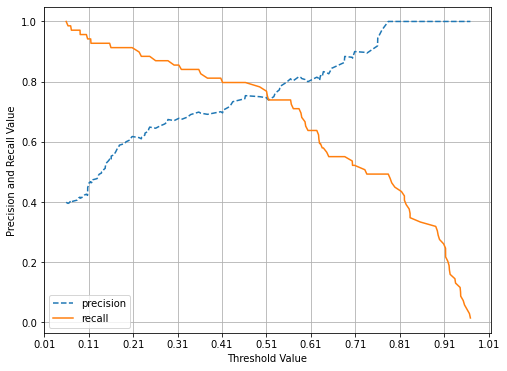

In [156]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### F1 Score

In [157]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7571


In [159]:
# 오차행렬, 정밀도, 재현율 
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accu = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1 Score
    
    print('오차 행렬')
    print(confusion)
    result = '정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1 스코어:{3:.4f}'
    print(result.format(accu, precision, recall,f1))

In [161]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

get_eval_by_threshold(y_test, pred_proba, thresholds)

현재 임계값:  0.4
오차 행렬
[[86 24]
 [13 56]]
정확도: 0.7933, 정밀도: 0.7000, 재현율: 0.8116, F1 스코어:0.7517
현재 임계값:  0.45
오차 행렬
[[91 19]
 [14 55]]
정확도: 0.8156, 정밀도: 0.7432, 재현율: 0.7971, F1 스코어:0.7692
현재 임계값:  0.5
오차 행렬
[[92 18]
 [16 53]]
정확도: 0.8101, 정밀도: 0.7465, 재현율: 0.7681, F1 스코어:0.7571
현재 임계값:  0.55
오차 행렬
[[97 13]
 [18 51]]
정확도: 0.8268, 정밀도: 0.7969, 재현율: 0.7391, F1 스코어:0.7669
현재 임계값:  0.6
오차 행렬
[[99 11]
 [25 44]]
정확도: 0.7989, 정밀도: 0.8000, 재현율: 0.6377, F1 스코어:0.7097


## 평가 지표 우선순위 (통상상황)

1. 정확도
2. f1 score
3. 정밀도, 재현율

### 성능 평가 지표 : ROC Curve & AUC score
- ROC Curve : roc_curve()

In [162]:
from sklearn.metrics import roc_curve

In [165]:
# 1의 예측 확률
pred_proba_v = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = \ # FP Ratios / TP Ratios / 임계값
roc_curve(
      y_test
    , pred_proba_v
)

In [166]:
len(thresholds)

52

In [170]:
# ROC Curve Chart function
def roc_curve_plot(y_test, pred_proba_p):
    fprs, tprs, thresholds = \
    roc_curve(y_test, pred_proba_p)
    
    plt.plot(fprs,tprs, label='ROC')
    plt.grid()
    plt.show()

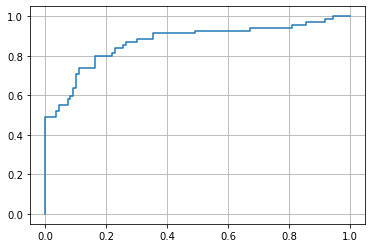

In [172]:
roc_curve_plot(y_test, pred_proba_v)

In [173]:
# AUC
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC Score: {0:.4f}'.format(roc_score))

ROC AUC Score: 0.8022
